<h1>METIS</h1>
<h3>Optimization Notebook</h3>

In [ ]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable
import math 

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/amirpandi/METIS/main/utils.py

from utils import *

## User Inputs

Main notebook that includes data processing and bayesian optimization function

In [ ]:
# General Parameters:
m = 20      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 20000
maximum_volume_of_model_output = 9300 # (i. e., total volume minus fixed parts/components. Avoid 0 for water.)
fixed_parts = {'Lysate':0.33, 'EnergyBuffer':0.175, 'IPTG-Water':0.025} # 33% of total volume is Lysate, 15% energy mix (except variable one), 2.5% IPTG
days_total = 10 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20 

#exploration = {1: 1.41, 2: 1.41, 3: 1.41,
#               4: 1.0, 5: 0.5}
exploration = {2: 1.41, 3: 1.41,
               4: 1.0, 5: 1.0, 6: 1.41, 7: 1.41,
               8: 1.41, 9: 1.41, 9: 1.0, 10: 0.5}

days_range = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20] # Number to Test each day

In [ ]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# It is recommended to first define the min and max conc, run this cell, see the concentrations generated by the model that are proportional to the stock concentration and the minimum pipetting volume. then from the suggested range choose the desired ones in conc_value and finally set min and max to None
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'PEG':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 'Conc_Stock':50.0, 'Alternatives':None},
 'DTT':{'Conc_Min':0.0, 'Conc_Max':4.0, 'Conc_Values':None, 'Conc_Stock':100.0, 'Alternatives':None},
 'Spermidine':{'Conc_Min':0.2, 'Conc_Max':2.0, 'Conc_Values':None, 'Conc_Stock':40.0, 'Alternatives':None},
 'T7Pol':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0078, 0.0156, 0.0273, 0.039, 0.0507, 0.0624, 0.0702, 0.078], 'Conc_Stock':0.78, 'Alternatives':None},
 't-RNA':{'Conc_Min':0.04, 'Conc_Max':0.04, 'Conc_Values':None, 'Conc_Stock':8.0, 'Alternatives':None},
 'AminoAcids':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.75], 'Conc_Stock':6.0, 'Alternatives':None},
 'TF-plasmid':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0,2.5,5.0,10.0,15.0,20.0,30.0,40.0,50.0,60.0,80.0,100.0], 'Conc_Stock':1000.0, 'Alternatives':None},
 'Circuit-plasmid':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[10.0], 'Conc_Stock':1000.0, 'Alternatives':['pTAC','pTHS','pDC','pSTAR']}}

In [ ]:
# Check Possible Concentrations
data_lists = {}
num = 0 
for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if not value['Conc_Values']:
        print('Your Min, Max :', "({}, {})".format(value['Conc_Min'], value['Conc_Max']))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter, verbose=0)
    print(concs)
    print(vols)
    data_lists[num] = vols
    num += 1
    print()

percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
print(percent, f'% of {pool_size} possible combination are executable!')
if pool_size > 10000000: pool_size = 10000000

Possible Conc For : PEG
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]

Possible Conc For : DTT
Your Min, Max : (0.0, 4.0)
[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
[0, 100, 200, 300, 400, 500, 600, 700, 800]

Possible Conc For : Spermidine
Your Min, Max : (0.2, 2.0)
[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

Possible Conc For : T7Pol
[0.0078, 0.0156, 0.0273, 0.039, 0.0507, 0.0624, 0.0702, 0.078]
[200.0, 400.0, 700.0, 1000.0, 1300.0, 1600.0, 1800.0, 2000.0]

Possible Conc For : t-RNA
Your Min, Max : (0.04, 0.04)
[0.04]
[100]

Possible Conc For : AminoAcids
[0.75]
[2500.0]

Possible Conc For : TF-plasmid
[0.0, 2.5, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 60.0, 80.0, 100.0]
[0.0, 50.0, 100.0, 200.0, 300.0, 400.0, 600.0, 800.0, 1000.0, 1200.0, 1600.0, 2000.0]

Possible Conc For : Circuit-plasmid
[10.0]
[200.0]

99.05606995884774 % of 77760 possible combina

In [ ]:
# add reference and negative control, these combinations will be implemented in concentrations and volume files
# leave it empty if you dont need, but still you need to run this cell
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***, for help you can see our other examples on METIS Github repo 


# used for day_4
specials = {

'Max_1':{'PEG':[3],'DTT':[4],'Spermidine':[0.4],'T7Pol':[0.0507],'t-RNA':[0.04],'AminoAcids':[0.75],'TF-plasmid':[50],'Circuit-plasmid':[10],
                'Circuit-plasmid_pTAC':[0],'Circuit-plasmid_pTHS':[1],'Circuit-plasmid_pDC':[0],'Circuit-plasmid_pSTAR':[0]},

'Max_2':{'PEG':[3],'DTT':[0],'Spermidine':[0.2],'T7Pol':[0.0507],'t-RNA':[0.04],'AminoAcids':[0.75],'TF-plasmid':[50],'Circuit-plasmid':[10],
                'Circuit-plasmid_pTAC':[0],'Circuit-plasmid_pTHS':[1],'Circuit-plasmid_pDC':[0],'Circuit-plasmid_pSTAR':[0]},

'Max_3':{'PEG':[3],'DTT':[0],'Spermidine':[0.4],'T7Pol':[0.0507],'t-RNA':[0.04],'AminoAcids':[0.75],'TF-plasmid':[50],'Circuit-plasmid':[10],
                'Circuit-plasmid_pTAC':[0],'Circuit-plasmid_pTHS':[1],'Circuit-plasmid_pDC':[0],'Circuit-plasmid_pSTAR':[0]},

'Max_4':{'PEG':[4],'DTT':[0],'Spermidine':[0.4],'T7Pol':[0.0507],'t-RNA':[0.04],'AminoAcids':[0.75],'TF-plasmid':[50],'Circuit-plasmid':[10],
                'Circuit-plasmid_pTAC':[0],'Circuit-plasmid_pTHS':[1],'Circuit-plasmid_pDC':[0],'Circuit-plasmid_pSTAR':[0]},

'Max_5':{'PEG':[4],'DTT':[1.5],'Spermidine':[0.2],'T7Pol':[0.0507],'t-RNA':[0.04],'AminoAcids':[0.75],'TF-plasmid':[50],'Circuit-plasmid':[10],
                'Circuit-plasmid_pTAC':[0],'Circuit-plasmid_pTHS':[1],'Circuit-plasmid_pDC':[0],'Circuit-plasmid_pSTAR':[0]}}

specials = {}

## Day 1 (in absence of Day_0)

In [ ]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=maximum_volume_of_model_output, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

Concentrations_1

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,4.0,2.0,0.6,0.0273,0.08,1.26,10.0,10.0,1.0,0.0,0.0,0.0
1,3.5,0.5,1.2,0.0624,0.16,1.26,20.0,10.0,0.0,1.0,0.0,0.0
2,3.0,1.5,1.2,0.0624,0.12,0.60,20.0,10.0,0.0,0.0,0.0,1.0
3,4.0,2.0,2.0,0.0780,0.12,1.11,5.0,10.0,0.0,1.0,0.0,0.0
4,1.5,3.0,1.0,0.0390,0.08,1.38,40.0,10.0,0.0,1.0,0.0,0.0
5,3.0,0.5,0.8,0.0156,0.04,1.11,100.0,10.0,1.0,0.0,0.0,0.0
6,4.5,1.0,1.4,0.0156,0.12,0.75,20.0,10.0,1.0,0.0,0.0,0.0
7,3.0,3.0,1.2,0.0702,0.16,1.11,60.0,10.0,0.0,0.0,0.0,1.0
8,5.0,3.0,0.6,0.0273,0.12,1.11,20.0,10.0,1.0,0.0,0.0,0.0
9,2.5,4.0,1.2,0.0156,0.12,0.90,100.0,10.0,0.0,1.0,0.0,0.0


In [ ]:
!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

In [ ]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)
Volumes_1

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_Type,Lysate,EnergyBuffer,IPTG-Water,water
0,1600.0,400.0,300.0,700.0,200.0,4200.0,100.0,200.0,pTAC,6600.0,3500.0,500.0,1700.0
1,1400.0,100.0,600.0,1600.0,400.0,4200.0,200.0,200.0,pTHS,6600.0,3500.0,500.0,700.0
2,1200.0,300.0,600.0,1600.0,300.0,2000.0,200.0,200.0,pSTAR,6600.0,3500.0,500.0,3000.0
3,1600.0,400.0,1000.0,2000.0,300.0,3700.0,50.0,200.0,pTHS,6600.0,3500.0,500.0,150.0
4,600.0,600.0,500.0,1000.0,200.0,4600.0,400.0,200.0,pTHS,6600.0,3500.0,500.0,1300.0
5,1200.0,100.0,400.0,400.0,100.0,3700.0,1000.0,200.0,pTAC,6600.0,3500.0,500.0,2300.0
6,1800.0,200.0,700.0,400.0,300.0,2500.0,200.0,200.0,pTAC,6600.0,3500.0,500.0,3100.0
7,1200.0,600.0,600.0,1800.0,400.0,3700.0,600.0,200.0,pSTAR,6600.0,3500.0,500.0,300.0
8,2000.0,600.0,300.0,700.0,300.0,3700.0,200.0,200.0,pTAC,6600.0,3500.0,500.0,1400.0
9,1000.0,800.0,600.0,400.0,300.0,3000.0,1000.0,200.0,pTHS,6600.0,3500.0,500.0,2100.0


## Other Days

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

0 4


In [ ]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,1.5,1.0,1.0,0.0273,0.12,1.50,40,10,0,0,1,0
1,1.0,4.0,1.6,0.0507,0.08,0.48,5,10,0,0,1,0
2,3.0,2.0,1.8,0.0507,0.08,0.48,5,10,0,1,0,0
3,2.5,4.0,0.2,0.0273,0.20,1.26,100,10,0,0,0,1
4,1.0,0.0,0.6,0.0273,0.08,1.11,60,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
175,3.0,4.0,0.4,0.0507,0.04,0.75,50,10,0,1,0,0
176,3.0,0.0,0.2,0.0507,0.04,0.75,50,10,0,1,0,0
177,3.0,0.0,0.4,0.0507,0.04,0.75,50,10,0,1,0,0
178,4.0,0.0,0.4,0.0507,0.04,0.75,50,10,0,1,0,0


In [ ]:
# ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter and scoring functions
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
pool_size

77760

In [ ]:
t0 = time.time()

pool_size = 10000 # for when you want to change pool size, default = all possible combinations

Concentrations_n_m = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                           final_order=final_order,
                                           df_main = aggregated_data_m,
                                           reaction_vol_nl=final_reaction_volume_nanoliter, max_nl=maximum_volume_of_model_output,
                                           drop_size_nl=minimum_drop_size_nanoliter,
                                           exploitation=1, exploration=exploration[day+1], test_size=20, pool_size=pool_size, verbose=0,
                                           day=day, days_range = days_range)

print("Passed Time(s): ",time.time()-t0)

Concentrations_n_m

Passed Time(s):  4.661105155944824


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,3.0,1.0,0.4,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0
1,2.5,0.0,0.6,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0
2,2.5,1.0,0.2,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0
3,2.5,1.5,0.4,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0
4,2.5,2.5,0.2,0.0078,0.04,0.75,5.0,10.0,0.0,1.0,0.0,0.0
5,3.0,2.0,0.2,0.0078,0.04,0.75,2.5,10.0,0.0,1.0,0.0,0.0
6,2.0,0.0,0.4,0.0078,0.04,0.75,2.5,10.0,0.0,1.0,0.0,0.0
7,2.5,1.5,0.2,0.0078,0.04,0.75,0.0,10.0,0.0,1.0,0.0,0.0
8,2.5,0.0,0.2,0.0078,0.04,0.75,10.0,10.0,0.0,1.0,0.0,0.0
9,3.5,1.5,0.4,0.0078,0.04,0.75,2.5,10.0,0.0,1.0,0.0,0.0


In [ ]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [ ]:
# check not to make repeated combination
df_main = aggregated_data_m

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

[left_only, right_only]
Categories (2, object): [left_only, right_only]

In [ ]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

# Visualising Results (BoxPlot)


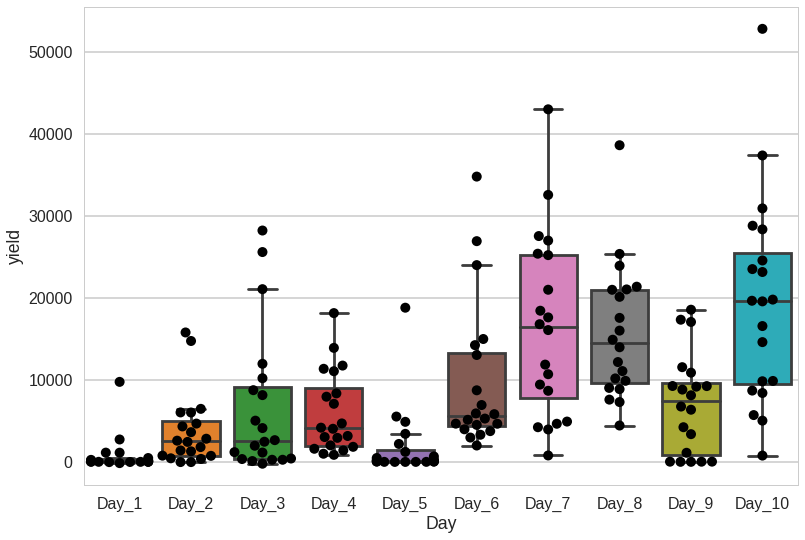

In [ ]:
display_std = False # if you have included "yield_std" column in Results.csv will show it else disply 0 for std
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = f'Day_{i}'
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

ax = sns.boxplot(x='Day', y='yield', data=Results_m, fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)

    errors = Results_m['std']
    ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ',color="grey", zorder=3, linewidth=1.2)
    print(errors, x_coords, y_coords)

ax

In [ ]:
fig.savefig(f'Day_{day-1}.png')

## Visualising Results (Based On Metabolites)

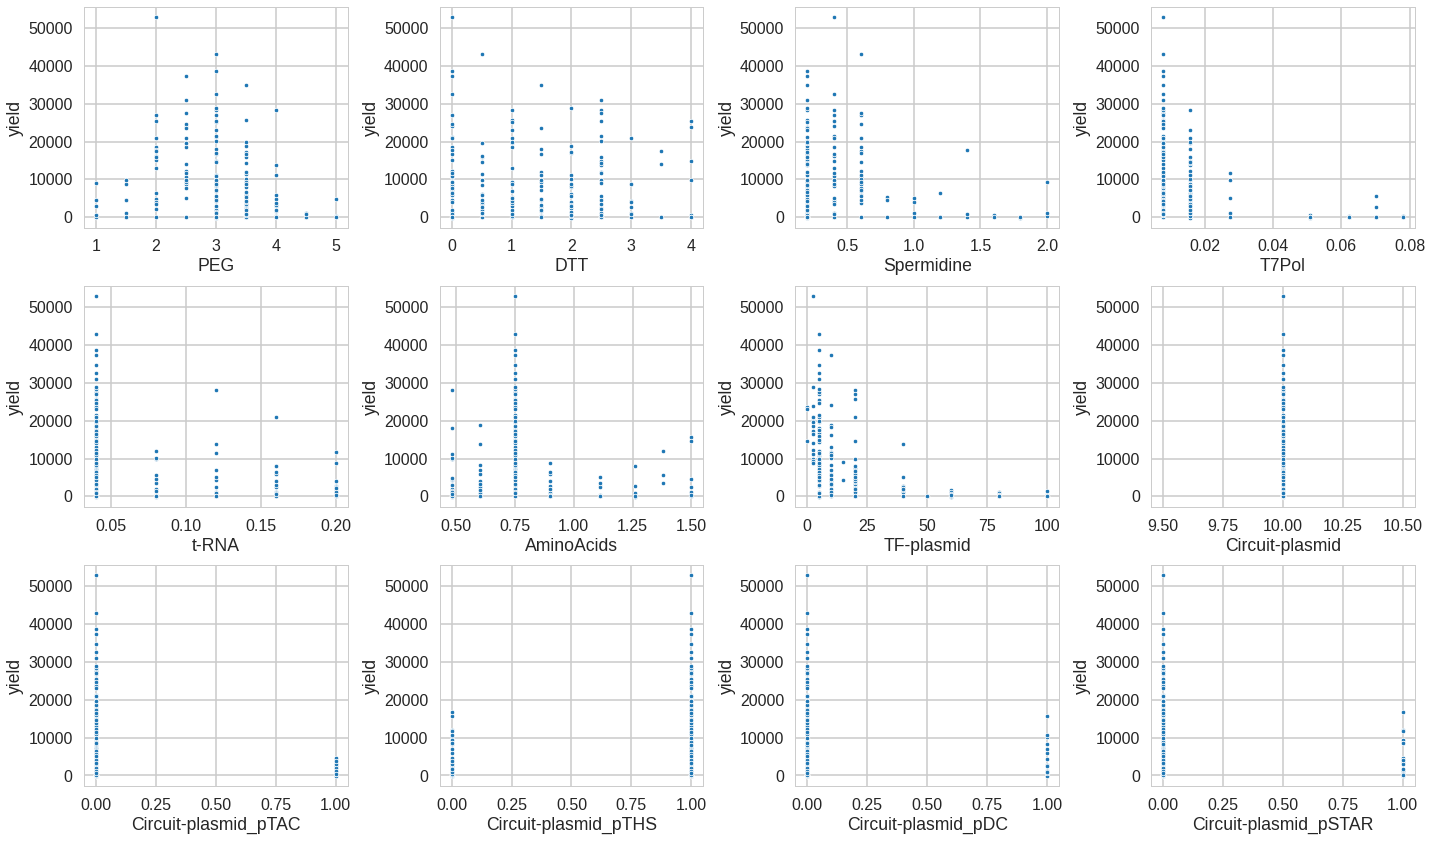

In [ ]:
desired_cols = []
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

plt.style.use('seaborn-whitegrid')

num = len(desired_cols)
dim = math.ceil(math.sqrt(num))
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)

fig = plt.figure(figsize=(20,15))
for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.scatterplot(x = desired_cols[i-1], y='yield', data=data, s=20)
fig.tight_layout()

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite.png')

# Viualising Concentrations From Day_1 to Now

In [ ]:
data_all

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,day
0,1.5,1.0,1.0,0.0273,0.12,1.50,40,10,Day_1
1,1.0,4.0,1.6,0.0507,0.08,0.48,5,10,Day_1
2,3.0,2.0,1.8,0.0507,0.08,0.48,5,10,Day_1
3,2.5,4.0,0.2,0.0273,0.20,1.26,100,10,Day_1
4,1.0,0.0,0.6,0.0273,0.08,1.11,60,10,Day_1
...,...,...,...,...,...,...,...,...,...
195,3.5,1.0,0.2,0.0156,0.04,0.75,5,10,Day_10
196,2.5,1.0,0.4,0.0273,0.04,0.75,5,10,Day_10
197,4.5,1.0,0.4,0.0078,0.04,0.75,5,10,Day_10
198,3.0,4.0,0.2,0.0273,0.04,0.75,5,10,Day_10


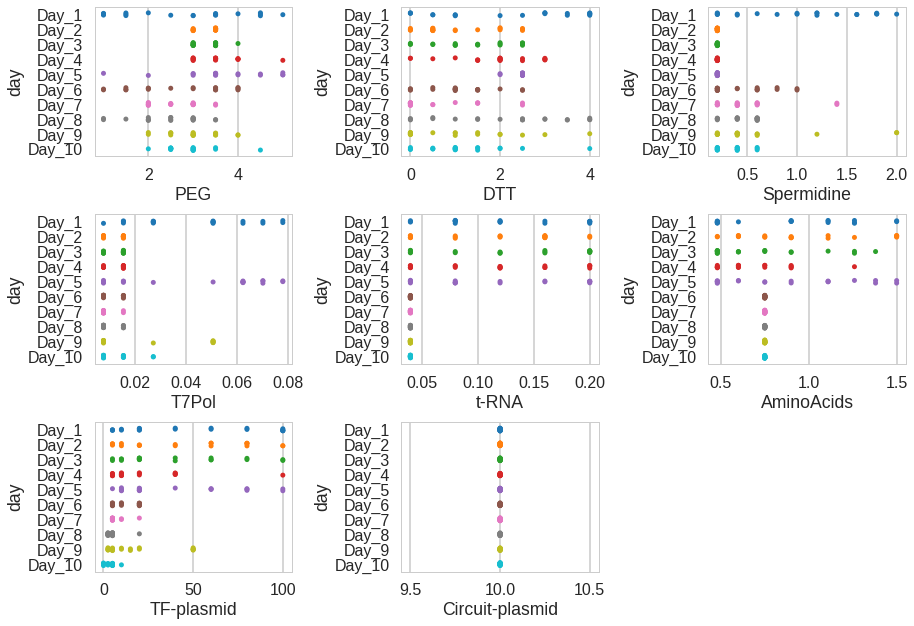

In [ ]:
data_all = pd.DataFrame(columns = list(concentrations_limits.keys())+['day'])

d = 0
no = 0

while no < 10:
    if os.path.exists(f'Results_{d}.csv'):
        data = pd.read_csv(f'Results_{d}.csv')
        data = data[[*list(concentrations_limits.keys())]]
        data['day'] = f'Day_{d}'
        data_all = pd.concat([data_all, data]).reset_index(drop=True)
    else:
        no += 1

    d += 1

plt.style.use('seaborn-whitegrid')

num = len(concentrations_limits)
dim = math.ceil(math.sqrt(num))


fig = plt.figure()

for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.stripplot(x=list(concentrations_limits.keys())[i-1], y="day", data=data_all)

fig.tight_layout()

In [ ]:
fig.savefig(f'Day_{day-1}_Concentrations.png')